In [25]:
import uproot as up
from pathlib import Path
import h5py as h5
import awkward as ak
from multiprocessing import Pool
from tqdm import tqdm
import mplhep as hep
from itertools import chain
import matplotlib as mpl
from matplotlib import pyplot as plt
hep.style.use("CMS")

In [26]:
fpath = '/tmp/0af947d6-3bf6-4176-83f2-c4ce2e8237ba.root'
fsig = '/tmp/ffd9f336-2d8a-4c6b-9ba6-4b0a2fb0dc17.root'

In [27]:
import sys
from functools import lru_cache
from typing import Callable
import uproot as up
import awkward as ak
import numpy as np
from pathlib import Path
import re
import json

from scipy.stats import binned_statistic


@lru_cache(maxsize=512)
def get(f: str, k: str, prefix='MuonSystem', **kwargs) -> ak.Array:
    "Cached reader for ROOT, add 'MuonSystem/' to the key if not present with relative path"
    if not k.startswith(prefix) and not k.startswith('/'):
        k = f"{prefix}/{k}"
    with up.open(f) as f:  # type: ignore
        return f[k].array(**kwargs)  # type: ignore


@lru_cache
def load_keys(fname):
    with up.open(fname) as f:  # type: ignore
        return _load_keys(f, '/')


from typing import Mapping


def _load_keys(f: Mapping, curdir):
    if not hasattr(f[curdir], 'keys'):
        return []
    ks = f[curdir].keys()
    ks = [k.split(';', 1)[0] for k in ks]
    ks = list(set(ks))
    ks = [f'{curdir}{k}/' for k in ks]
    for i in range(len(ks)):
        k = ks[i]
        _ks = _load_keys(f, k)
        if not _ks:
            ks[i] = k[:-1]
        ks.extend(_ks)
    return ks


def search(fname: str | Path, k: str):
    m = re.compile(k, re.IGNORECASE)
    ks = load_keys(fname)
    k = k.lower()
    return list(np.unique([k for k in ks if m.search(k.lower())]))


In [28]:
# search('/tmp/db2adc56-589d-499e-b220-af739ff14512.root', 'puppimet')

In [29]:
def unified_lumi_idx(run, lumi):
    return 1000000 * run + lumi

def unified_lumi_idx_from_json(golden_json):
    arr = []
    for r, ls in golden_json.items():
        run = int(r)
        for l1, l2 in ls:
            _l1 = unified_lumi_idx(run, int(l1))
            _l2 = unified_lumi_idx(run, int(l2))
            arr.append((_l1, _l2))
    return np.array(list(zip(*arr)) )      


def golden_json_mask(run:np.ndarray, lumi:np.ndarray, golden_json:dict[str, list[tuple[int, int]]]) -> np.ndarray:
    low, high = unified_lumi_idx_from_json(golden_json)
    idx = unified_lumi_idx(run, lumi)
    l = np.searchsorted(low,idx, side='right') -1
    r = np.searchsorted(high,idx, side='left')
    return l == r


def load_good_json():
    cert = {}
    for fn in Path('../../data/Certification').glob('*.json'):
        with open(fn) as f:
            cert.update(json.load(f))
    return cert


In [30]:
def get_met_no_mu(event: dict[str, np.ndarray]) -> np.ndarray:
    met_pt = event['PuppiMET_pt']
    met_phi = event['PuppiMET_phi']
    mu_pt = event['Muon_pt']
    mu_phi = event['Muon_phi']
    
    met_x, met_y = met_pt * np.cos(met_phi), met_pt * np.sin(met_phi)
    mu_x, mu_y = mu_pt * np.cos(mu_phi), mu_pt * np.sin(mu_phi)
    return np.sqrt((met_x + mu_x)**2 + (met_y + mu_y)**2) # Effective by removing the muon

def selection(event: dict[str, np.ndarray]) -> np.ndarray:
    mu_pt = event['Muon_pt']

    muon_id_tight = event['Muon_pfRelIso04_all'] <= 0.15
    
    mask = event['HLT_IsoMu27']
    mask &= mu_pt <= 100
    mask &= mu_pt >= 30
    mask &= muon_id_tight
    
    mask &= event['Flag_goodVertices']
    mask &= event['Flag_globalSuperTightHalo2016Filter']
    mask &= event['Flag_EcalDeadCellTriggerPrimitiveFilter']
    mask &= event['Flag_BadPFMuonFilter']
    mask &= event['Flag_BadPFMuonDzFilter']
    mask &= event['Flag_hfNoisyHitsFilter']
    mask &= event['Flag_eeBadScFilter']

    if 'run' in event:
        print('Using golden json')
        cert = load_good_json()
        mask &= golden_json_mask(event['run'].astype(np.int64), event['luminosityBlock'].astype(np.int64), cert)
    
    return mask

def get_masked_eff_met_and_hlt(event: dict[str, np.ndarray]) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    mask = selection(event)
    met_no_mu = get_met_no_mu(event)
    hlt_mask = event['HLT_PFMETNoMu120_PFMHTNoMu120_IDTight']
    if 'weight' in event:
        weights = event['weight'][mask]
    else:
        weights = np.ones(mask.sum(), dtype=np.float32)
    return met_no_mu[mask], hlt_mask[mask], weights

In [31]:
def _load_cache(fname: str | Path) -> dict[str, np.ndarray]:
    with h5.File(fname, 'r') as f:
        return {k: np.array(v) for k, v in f.items()}


def load_cache(*fnames: str | Path, j=8) -> dict[str, np.ndarray]:
    pool = Pool(j)
    iter = chain.from_iterable((Path(f).glob('*.h5') for f in fnames))
    r = pool.map(_load_cache, iter)
    return {k: np.concatenate([d[k] for d in r]) for k in r[0]}

In [32]:
events = load_cache('/data/massive1/LLP/trig_eff/data/Run2022A')

In [33]:
def get_pu_weight(campaign:str, pu:np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    with open(f'../../data/PileupWeights/{campaign}.json') as jf:  # type: ignore
        data = json.load(jf)
        w_nominal_map = np.array(data['corrections'][0]['data']['content'][0]['value']['content'])
        w_up_map = np.array(data['corrections'][0]['data']['content'][1]['value']['content'])
        w_down_map = np.array(data['corrections'][0]['data']['content'][2]['value']['content'])
        x = np.arange(0, 99) + 0.5
        w = np.interp(pu, x, w_nominal_map)
        w_up = np.interp(pu, x, w_up_map)
        w_down = np.interp(pu, x, w_down_map)

    return w, w_up, w_down


In [34]:
from scipy.stats import norm
from scipy.stats import beta, norm
import numpy as np

def wilson_int(n, p, z=1.):

    n = np.maximum(1e-9, n)
    _p = p / n 
    
    denom = 1 + z**2/n
    c = (_p + z**2/(2*n))/denom
    sp = z * np.sqrt(_p*(1-_p)/n + z**2/(4*n**2))/denom
    
    down = np.clip(c - sp, 0, _p) # numerical stability
    up = np.clip(c + sp, _p, 1)
    
    return down, up, _p


def clopper_pearson(n, p, z=1.):
    alpha = norm.cdf(-z) * 2
    alpha = np.full(np.shape(n), alpha)
    n = np.maximum(1e-9, n)
    _p = p / n
    down, up = beta.ppf([alpha/2, 1 - alpha/2], [p, p + 1], [n - p + 1, n - p])
    up = np.nan_to_num(up, nan=1)
    down = np.nan_to_num(down, nan=0)

    return down, up, _p


def ratio_err(a, a_high, a_low, b, b_high, b_low):
    a_err = np.maximum(a_high - a, a - a_low)
    b_err = np.maximum(b_high - b, b - b_low)
    r = a/b
    err = r * np.sqrt((a_err/a)**2 + (b_err/b)**2)
    return r, err


In [35]:
campaigns = {
    'Summer22': ('2022B', '2022C', '2022D'),
    'Summer22EE': ('2022E', '2022F', '2022G'),
    'Summer23': ('2023B', '2023C'),
    'Summer23BPix': ('2023D',),
    'Winter24': tuple(f'2024{c}' for c in 'BCDEFGHI')
}

In [36]:
cert = load_good_json()

In [37]:
# import gzip
# gfname = '../../data/JetVetoMap/Summer22.json.gz'
# with gzip.open(gfname, 'rt') as f:
#     jet_veto_map = json.load(f)

In [38]:
# arr2 = load_cache('/data/massive1/LLP/trig_eff/data2/Run2022E')
# arr3 = load_cache('/data/massive1/LLP/trig_eff/data3/Run2022E')

In [39]:
# len(arr2['run']), len(arr3['run'])

In [40]:
# arr_data = load_cache(*(f'/data/massive1/LLP/trig_eff/data3/Run{era}' for era in ['2022B', '2022C', '2022D']))
# arr_mc = load_cache(f'/data/massive1/LLP/trig_eff/mc2/Summer22')

In [41]:
# met_no_mu, hlt, w = get_masked_eff_met_and_hlt(arr_data)

In [42]:
# plt.hist(met_no_mu, bins=100, range=(0, 1000), histtype='step', label='MET no muon')
# # plt.hist(met, bins=100, range=(0, 1000), histtype='step', label='MET')
# plt.legend()
# plt.yscale('log')
# plt.show()

In [43]:
# eff_met_data, hlt_mask_data, w_data = get_masked_eff_met_and_hlt(arr_data)
# eff_met_sig, hlt_mask_sig, w_sig = get_masked_eff_met_and_hlt(arr_mc)

# bins = np.concatenate((np.arange(0,400,20), [400,450, 600,700,800,1000]))
# # bins = np.linspace(0, 7, 31)
# cnt_stat_data = binned_statistic(eff_met_data, w_data, bins=bins, statistic='sum')
# cnt_stat_sig = binned_statistic(eff_met_sig, w_sig, bins=bins, statistic='sum')
# sum_stat_data = binned_statistic(eff_met_data, hlt_mask_data * w_data, bins=bins, statistic='sum')
# sum_stat_sig = binned_statistic(eff_met_sig, hlt_mask_sig * w_sig, bins=bins, statistic='sum')


# r_data_low, r_data_high, r_data_est = clopper_pearson(cnt_stat_data.statistic, sum_stat_data.statistic)
# r_sig_low, r_sig_high, r_sig_est = clopper_pearson(cnt_stat_sig.statistic, sum_stat_sig.statistic)
# centers = (bins[1:] + bins[:-1]) / 2
# h_err = (bins[1:] - bins[:-1]) / 2

# r, err = ratio_err(r_data_est, r_data_high, r_data_low, r_sig_est, r_sig_high, r_sig_low)

In [44]:
# fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
# ax0, ax1 = axs
# ax0: plt.Axes
# ax1: plt.Axes
# ax0.errorbar(centers, r_sig_est, [r_sig_est - r_sig_low, r_sig_high - r_sig_est], xerr=h_err*0.97, fmt='.', label='Summer22EE', capsize=3, color='red')
# ax0.errorbar(centers, r_data_est, [r_data_est - r_data_low, r_data_high - r_data_est], xerr=h_err*0.97, fmt='.', label='Run2022B+C+D', capsize=3, color='blue', alpha=1.)
# ax0.set_ylabel('Efficiency')
# ax0.legend()

# err_mc = np.maximum(r_sig_est - r_sig_low, r_sig_high - r_sig_est) / r_sig_est
# ax1.bar(centers, 2*err_mc, color='red', alpha=0.5, width=np.diff(bins)-3, bottom=1-err_mc)

# ax1.axhline(1, color='gray', linestyle='--')
# ax1.errorbar(centers, r, err, xerr=h_err*0.97, fmt='.', color='black')
# ax1.set_xlabel('MET no muon')
# ax1.set_ylim(-0.5,2.5)
# ax1.set_ylabel(r'sf')
# plt.tight_layout()
# plt.show()

In [45]:
Path('/tmp/sf').mkdir(exist_ok=True, parents=True)

In [46]:
prefix = '/data/massive1/LLP/trig_eff'
version = 4

In [47]:
def plot_sf_vs_met(campaign:str, eras:tuple[str,...]):
                   

    arr_data = load_cache(*(f'{prefix}/data{version}/Run{era}' for era in eras))
    arr_mc = load_cache(f'{prefix}/mc{version}/{campaign}')
    data_label = f'Run{eras[0]}-{eras[-1][-1]}' if len(eras) > 1 else f'Run{eras[0]}'
    
    print(1)

    eff_met_data, hlt_mask_data, w_data = get_masked_eff_met_and_hlt(arr_data)
    eff_met_sig, hlt_mask_sig, w_sig = get_masked_eff_met_and_hlt(arr_mc)

    bins = np.concatenate((np.arange(0,400,20), [400,450, 600,700,800,1000]))
    # bins = np.linspace(0, 7, 31)
    cnt_stat_data = binned_statistic(eff_met_data, w_data, bins=bins, statistic='sum')
    cnt_stat_sig = binned_statistic(eff_met_sig, w_sig, bins=bins, statistic='sum')
    sum_stat_data = binned_statistic(eff_met_data, hlt_mask_data * w_data, bins=bins, statistic='sum')
    sum_stat_sig = binned_statistic(eff_met_sig, hlt_mask_sig * w_sig, bins=bins, statistic='sum')
    
    print(2)

    r_data_low, r_data_high, r_data_est = clopper_pearson(cnt_stat_data.statistic, sum_stat_data.statistic)
    r_sig_low, r_sig_high, r_sig_est = clopper_pearson(cnt_stat_sig.statistic, sum_stat_sig.statistic)
    centers = (bins[1:] + bins[:-1]) / 2
    h_err = (bins[1:] - bins[:-1]) / 2

    r, err = ratio_err(r_data_est, r_data_high, r_data_low, r_sig_est, r_sig_high, r_sig_low)
    
    print(3)

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    ax0, ax1 = axs
    ax0: plt.Axes
    ax1: plt.Axes
    ax0.errorbar(centers, r_sig_est, [r_sig_est - r_sig_low, r_sig_high - r_sig_est], xerr=h_err*0.97, fmt='.', label=campaign, capsize=3, color='red')
    ax0.errorbar(centers, r_data_est, [r_data_est - r_data_low, r_data_high - r_data_est], xerr=h_err*0.97, fmt='.', label=data_label, capsize=3, color='blue', alpha=1.)
    ax0.set_ylabel('Efficiency')
    ax0.legend()

    err_mc = np.maximum(r_sig_est - r_sig_low, r_sig_high - r_sig_est) / r_sig_est
    ax1.bar(centers, 2*err_mc, color='red', alpha=0.5, width=np.diff(bins)-3, bottom=1-err_mc)

    ax1.axhline(1, color='gray', linestyle='--')
    ax1.errorbar(centers, r, err, xerr=h_err*0.97, fmt='.', color='black')
    ax1.set_xlabel('MET no muon [GeV]')
    ax1.set_ylim(-0,2)
    ax1.set_ylabel(r'sf')
    plt.tight_layout()
    return r, err, bins


def plot_data_trig_eff(eras:tuple[str,...], color='blue'):
                   

    arr_data = load_cache(*(f'{prefix}/data{version}/Run{era}' for era in eras))
    # data_label = 'Run'+'+'.join([eras[0], *(s[-1] for s in eras[1:])])
    data_label = f'Run{eras[0]}-{eras[-1][-1]}' if len(eras) > 1 else f'Run{eras[0]}'
    
    print(1)

    eff_met_data, hlt_mask_data, w_data = get_masked_eff_met_and_hlt(arr_data)

    bins = np.concatenate((np.arange(0,400,20), [400,450, 600,700,800,1000]))
    # bins = np.linspace(0, 7, 31)
    cnt_stat_data = binned_statistic(eff_met_data, w_data, bins=bins, statistic='sum')
    sum_stat_data = binned_statistic(eff_met_data, hlt_mask_data * w_data, bins=bins, statistic='sum')
    
    print(2)

    r_data_low, r_data_high, r_data_est = clopper_pearson(cnt_stat_data.statistic, sum_stat_data.statistic)
    centers = (bins[1:] + bins[:-1]) / 2
    h_err = (bins[1:] - bins[:-1]) / 2

    
    print(3)

    ax0 = plt.gca()
    ax0: plt.Axes
    ax0.errorbar(centers, r_data_est, [r_data_est - r_data_low, r_data_high - r_data_est], xerr=h_err*0.97, fmt='.', label=data_label, capsize=3, color=color, alpha=1.)
    ax0.set_ylabel('Efficiency')
    ax0.legend()
    ax0.set_xlabel('MET no muon [GeV]')
    # plt.tight_layout()
    # return r, err, bins

1
Using golden json
2
3


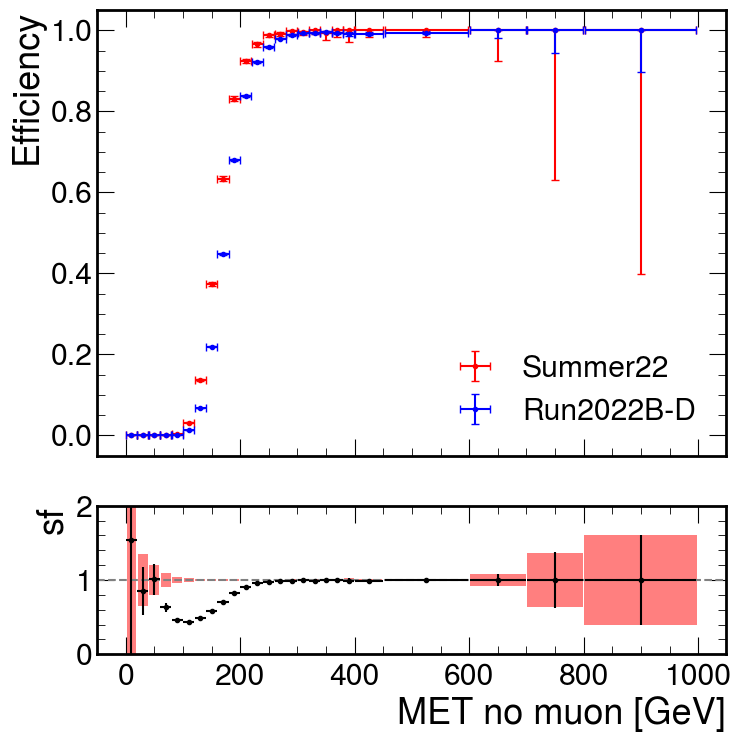

In [24]:
campaign = 'Summer22'
r, err, bins = plot_sf_vs_met(campaign, campaigns[campaign])
plt.savefig(f'/tmp/sf/{campaign}.pdf', bbox_inches='tight')

1
Using golden json
2
3
1
Using golden json
2
3
1
Using golden json
2
3


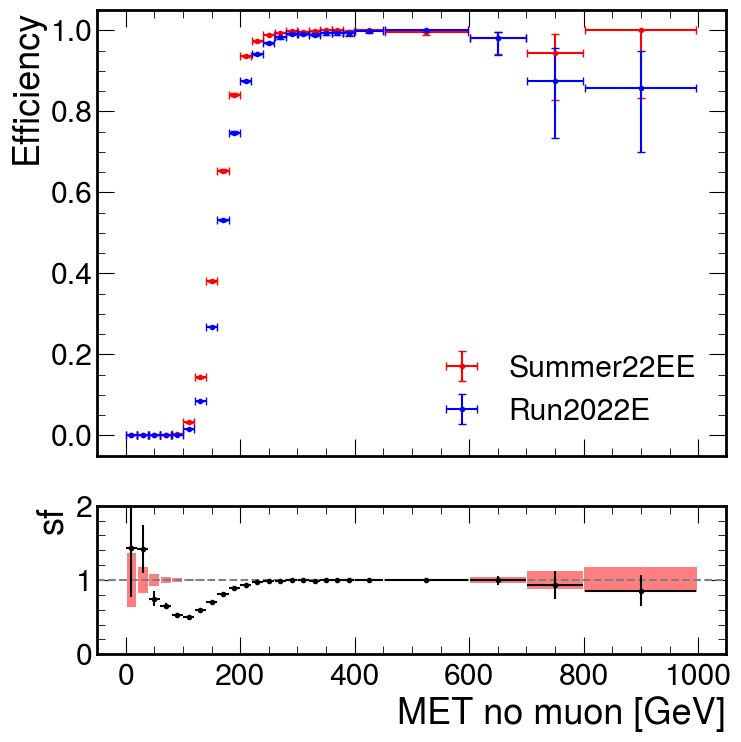

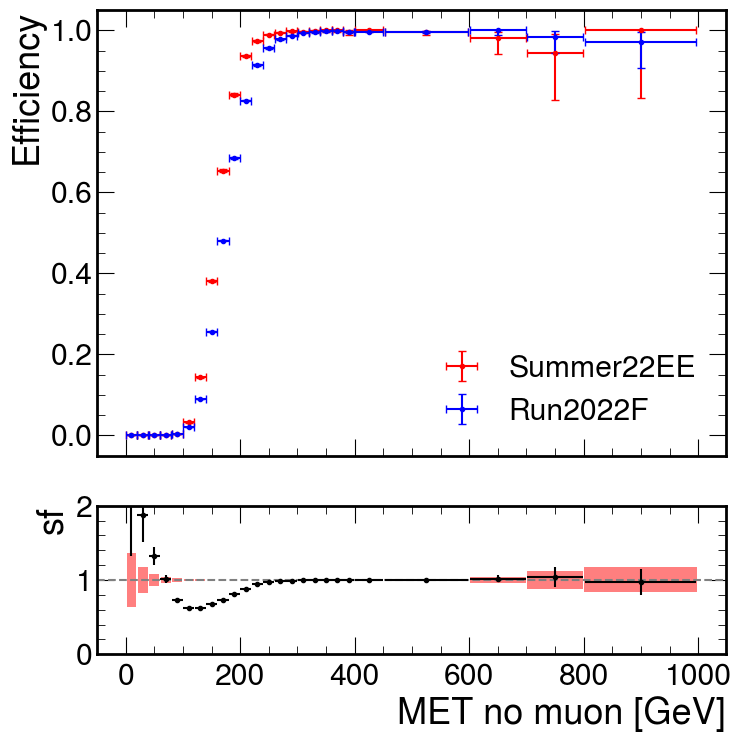

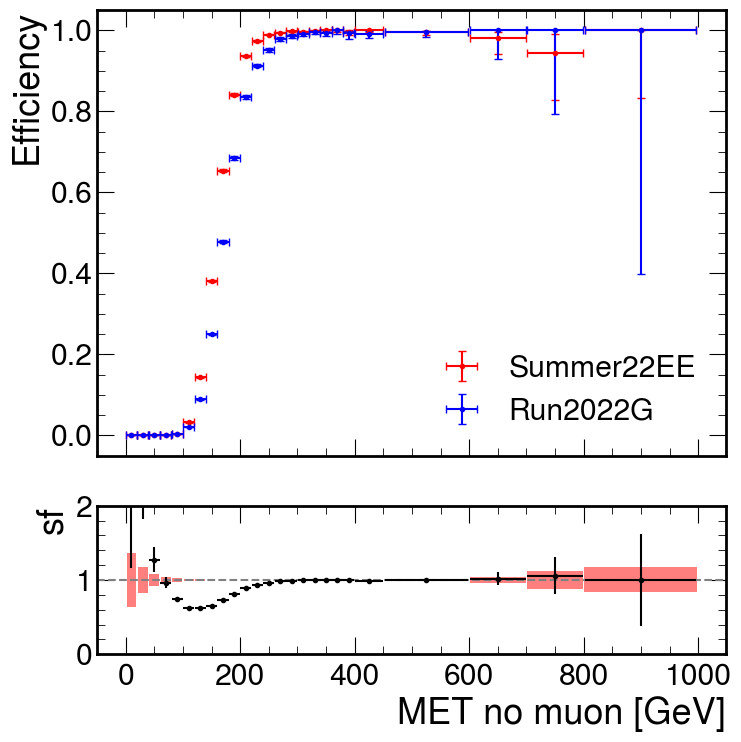

In [49]:
r, err, bins = plot_sf_vs_met('Summer22EE', ('2022E',))
plt.savefig(f'/tmp/sf/22E.pdf', bbox_inches='tight')
r, err, bins = plot_sf_vs_met('Summer22EE', ('2022F',))
plt.savefig(f'/tmp/sf/22F.pdf', bbox_inches='tight')
r, err, bins = plot_sf_vs_met('Summer22EE', ('2022G',))
plt.savefig(f'/tmp/sf/22G.pdf', bbox_inches='tight')

1
Using golden json
2
3


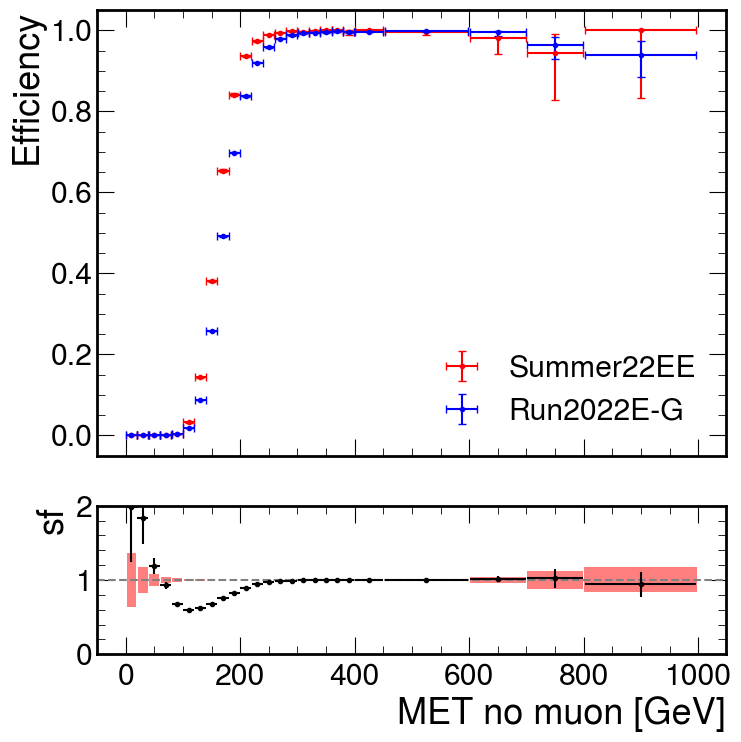

In [25]:
campaign = 'Summer22EE'
r, err, bins = plot_sf_vs_met('Summer22EE', campaigns[campaign])
plt.savefig(f'/tmp/sf/{campaign}.pdf', bbox_inches='tight')

1
Using golden json
2
3


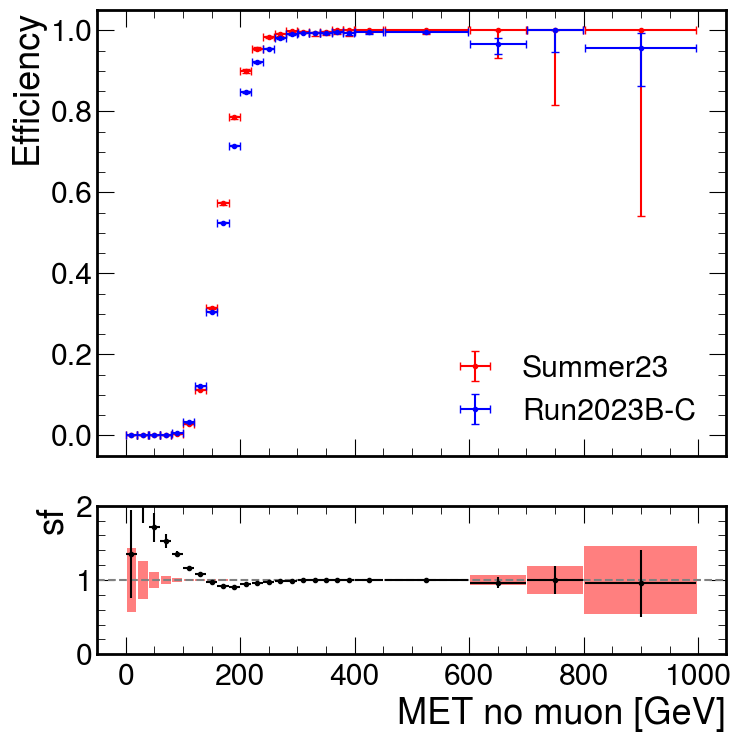

In [26]:
campaign = 'Summer23'
r, err, bins = plot_sf_vs_met(campaign, campaigns[campaign])
plt.savefig(f'/tmp/sf/{campaign}.pdf', bbox_inches='tight')

1
Using golden json
2
3


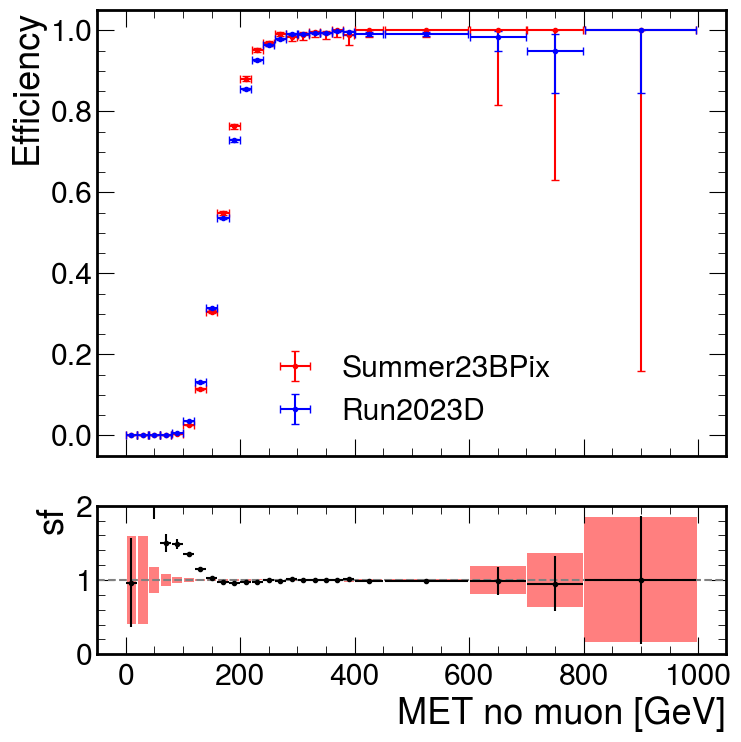

In [27]:
campaign = 'Summer23BPix'
r, err, bins = plot_sf_vs_met(campaign, campaigns[campaign])
plt.savefig(f'/tmp/sf/{campaign}.pdf', bbox_inches='tight')

1
Using golden json
2
3


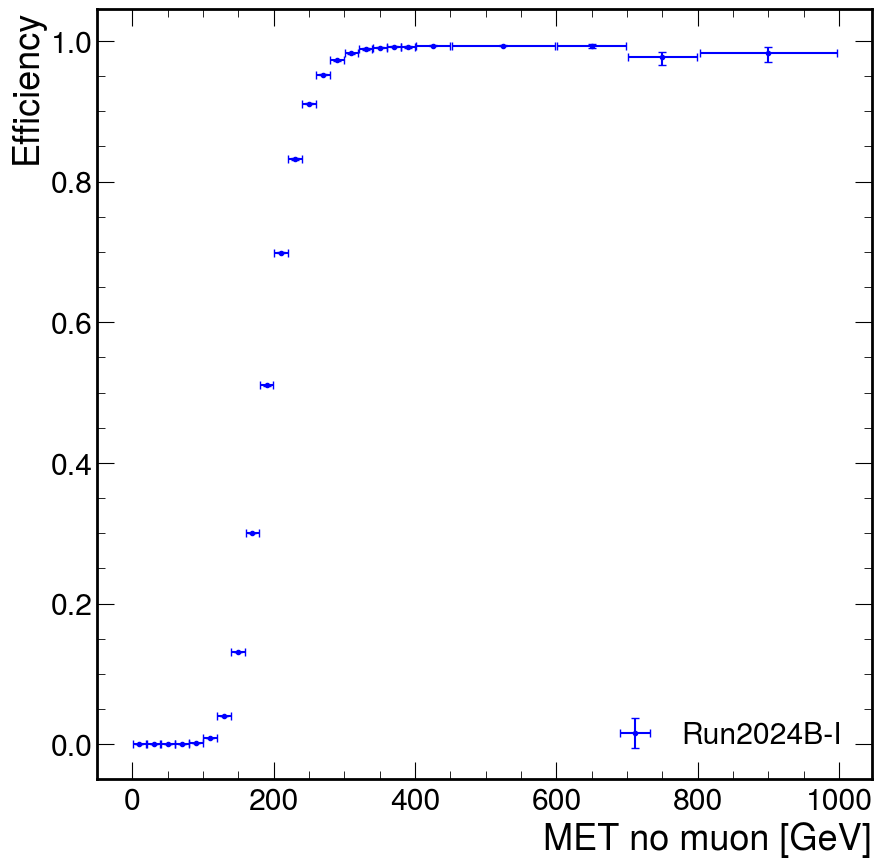

In [28]:
campaign = 'Winter24'
plot_data_trig_eff(campaigns[campaign])
plt.savefig(f'/tmp/sf/{campaign}.pdf', bbox_inches='tight')

In [29]:
import gc
gc.collect()

22475

In [ ]:
import gc
plot_data_trig_eff(campaigns['Winter24'], color='orange')
gc.collect()
plot_data_trig_eff(campaigns['Summer22'], color='red')
gc.collect()
plot_data_trig_eff(campaigns['Summer22EE'], color='blue')
gc.collect()
plot_data_trig_eff(campaigns['Summer23'], color='green')
gc.collect()
plot_data_trig_eff(campaigns['Summer23BPix'], color='purple')
gc.collect()
plt.savefig(f'/tmp/sf/consistency.pdf', bbox_inches='tight')

1
Using golden json
2
3
1
Using golden json
2
3


/tmp/ipykernel_919162/1878262452.py:83: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


1
Using golden json
2
3
1
Using golden json
2
3
